In [1]:
import pandas as pd
import geopandas as gpd
import datetime
import numpy as np
from shapely.geometry import Point, LineString
import shapely.wkt
import matplotlib.pyplot as plt
%matplotlib inline

#doc on accelerometer
# http://www.starlino.com/imu_guide.html

## Load original data

In [2]:
#phone info
f = open('track.txt','r')
phone = f.readline()
print 'phone info:',phone
f.close()



phone info: motorola Moto G (4);7.0;1.1.6;2.0.4;video



In [3]:
#read original data from file within track.txt.gz used by OSC to store sensor data
data = pd.read_csv('track.txt',sep=';',
                   skiprows=[0],
                   skipfooter=1,
                   usecols=[0,1,2,3,4,5,9,10,11,16,17,18],
                   header=None,
                   engine = 'python')

#naming of columns 
names = ['timestamp','long','lat','elevation','horizontal_accu',
         'GPSspeed','accelerationX','accelerationY','accelerationZ',
         'gravityX','gravityY','gravityZ'
        ]

data.columns=names

data.head()


,timestamp,long,lat,elevation,horizontal_accu,GPSspeed,accelerationX,accelerationY,accelerationZ,gravityX,gravityY,gravityZ
0,1.492177e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.492177e+09,NaN,NaN,NaN,NaN,NaN,-0.469606,0.126763,-0.394292,NaN,NaN,NaN
2,1.492177e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.492177e+09,NaN,NaN,NaN,NaN,NaN,-0.469606,0.126763,-0.394292,NaN,NaN,NaN
4,1.492177e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.205934,0.19355,0.959234


In [4]:
#conversion into timestamp
dates = []
for i in range(data.shape[0]):
    try:
        dates.append(datetime.datetime.fromtimestamp(data['timestamp'].iloc[i]))
    except :
        print 'Error with row:', i
data['timestamp'] = dates        
data.head()

,timestamp,long,lat,elevation,horizontal_accu,GPSspeed,accelerationX,accelerationY,accelerationZ,gravityX,gravityY,gravityZ
0,2017-04-14 09:35:19.833742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-04-14 09:35:19.833626,NaN,NaN,NaN,NaN,NaN,-0.469606,0.126763,-0.394292,NaN,NaN,NaN
2,2017-04-14 09:35:19.843359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-04-14 09:35:19.843273,NaN,NaN,NaN,NaN,NaN,-0.469606,0.126763,-0.394292,NaN,NaN,NaN
4,2017-04-14 09:35:19.843216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.205934,0.19355,0.959234


In [5]:
#remove all empty rows except timestamp
emtpy = data.iloc[:,1:].isnull().sum(axis=1) == data.shape[1]-1
data = data.loc[~emtpy,:]
data.index=range(data.shape[0])

data.head()

,timestamp,long,lat,elevation,horizontal_accu,GPSspeed,accelerationX,accelerationY,accelerationZ,gravityX,gravityY,gravityZ
0,2017-04-14 09:35:19.833626,NaN,NaN,NaN,NaN,NaN,-0.469606,0.126763,-0.394292,NaN,NaN,NaN
1,2017-04-14 09:35:19.843273,NaN,NaN,NaN,NaN,NaN,-0.469606,0.126763,-0.394292,NaN,NaN,NaN
2,2017-04-14 09:35:19.843216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.205934,0.19355,0.959234
3,2017-04-14 09:35:19.853097,NaN,NaN,NaN,NaN,NaN,-0.469606,0.126763,-0.394292,NaN,NaN,NaN
4,2017-04-14 09:35:19.853047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.205934,0.19355,0.959234


In [6]:
#short sample of data with gps data in teh extremes
#data from 49 to 451 with 250 in the middle
#choose long lat and acc data
#calcular la distancia euclidiana
dataClip = data.loc[49:451,['long','lat','accelerationX','accelerationY','accelerationZ']]

dataClip.dropna(axis=0,how='all',inplace=True)

dataClip.to_csv('testcase.csv',index_label=False)
dataClip.head()

,long,lat,accelerationX,accelerationY,accelerationZ
49,-73.971799,40.643469,NaN,NaN,NaN
50,NaN,NaN,-0.336876,0.083558,0.261692
52,NaN,NaN,-0.640812,0.265264,0.193743
54,NaN,NaN,-0.640812,0.265264,0.193743
56,NaN,NaN,-0.640812,0.265264,0.193743


## Geography

In [7]:
print 'GPS data points for clip data:'
gpsDataPoints =  dataClip.loc[~ (dataClip['long'].isnull()),['long','lat']]
gpsDataPoints['pointIndex'] = gpsDataPoints.index
gpsDataPoints

GPS data points for clip data:


,long,lat,pointIndex
49,-73.971799,40.643469,49
250,-73.971850,40.643462,250
451,-73.971901,40.643456,451


In [8]:
geometry = []
for i in range(len(gpsDataPoints.index)):
    if i == (len(gpsDataPoints.index)-1):
        line = np.nan
    else:
        #get start and end points for each line
        startPoint = Point(gpsDataPoints['long'].loc[gpsDataPoints.index[i]], gpsDataPoints['lat'].loc[gpsDataPoints.index[i]])
        endPoint = Point(gpsDataPoints['long'].loc[gpsDataPoints.index[i+1]], gpsDataPoints['lat'].loc[gpsDataPoints.index[i+1]])
        #convert to shapely wkt
        line = LineString([startPoint,endPoint]).wkt
        geometry.append(shapely.wkt.loads(line))

geometry


In [9]:
gpsDataPoints = gpsDataPoints.iloc[:-1]
crs = {'init': 'epsg:4326'}
gpsDataPoints = gpd.GeoDataFrame(gpsDataPoints, crs=crs, geometry=geometry)
gpsDataPoints

,long,lat,pointIndex,geometry
49,-73.971799,40.643469,49,"LINESTRING (-73.97179916 40.64346946, -73.9718..."
250,-73.971850,40.643462,250,"LINESTRING (-73.97184982 40.64346192, -73.9719..."


## Total vector from XYZ

In [10]:
dataClip = dataClip.merge(gpsDataPoints.drop(['geometry'],axis=1),how='left')
dataClip.head()

,long,lat,accelerationX,accelerationY,accelerationZ,pointIndex
0,-73.971799,40.643469,NaN,NaN,NaN,49.0
1,NaN,NaN,-0.336876,0.083558,0.261692,NaN
2,NaN,NaN,-0.640812,0.265264,0.193743,NaN
3,NaN,NaN,-0.640812,0.265264,0.193743,NaN
4,NaN,NaN,-0.640812,0.265264,0.193743,NaN


In [11]:
dataClip['pointIndex'] = dataClip['pointIndex'].fillna(method='ffill')
dataClip.head()

,long,lat,accelerationX,accelerationY,accelerationZ,pointIndex
0,-73.971799,40.643469,NaN,NaN,NaN,49.0
1,NaN,NaN,-0.336876,0.083558,0.261692,49.0
2,NaN,NaN,-0.640812,0.265264,0.193743,49.0
3,NaN,NaN,-0.640812,0.265264,0.193743,49.0
4,NaN,NaN,-0.640812,0.265264,0.193743,49.0


In [12]:
#dataOrig = dataClip.copy()

In [13]:
#dataClip = dataOrig.copy()

In [14]:
dataClipShifted = dataClip.shift(1)
dataClipShifted.drop(['long','lat','pointIndex'],axis=1,inplace=True)
dataClipShifted.columns = ['accelerationXShift','accelerationYShift','accelerationZShift']
dataClip = pd.concat([dataClip,dataClipShifted],axis=1)
dataClip.drop(['long','lat'],axis=1,inplace=True)
dataClip.dropna(axis=0,how='any',inplace=True)

dataClipShifted.head()

,accelerationXShift,accelerationYShift,accelerationZShift
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,-0.336876,0.083558,0.261692
3,-0.640812,0.265264,0.193743
4,-0.640812,0.265264,0.193743


In [15]:
dataClip.head()

,accelerationX,accelerationY,accelerationZ,pointIndex,accelerationXShift,accelerationYShift,accelerationZShift
2,-0.640812,0.265264,0.193743,49.0,-0.336876,0.083558,0.261692
3,-0.640812,0.265264,0.193743,49.0,-0.640812,0.265264,0.193743
4,-0.640812,0.265264,0.193743,49.0,-0.640812,0.265264,0.193743
5,-0.640812,0.265264,0.193743,49.0,-0.640812,0.265264,0.193743
6,-0.640812,0.265264,0.193743,49.0,-0.640812,0.265264,0.193743


## Calculating vector

$ (x_1 -x_1lag)^2 +  (y_1 - y_1lag)^2 + (z_1 - z_1lag)^2 $

In [16]:
dataClip['V'] = (dataClip.accelerationX-dataClip.accelerationXShift) ** 2 + \
    (dataClip.accelerationY-dataClip.accelerationYShift) ** 2 + \
    (dataClip.accelerationZ-dataClip.accelerationZShift) ** 2 

In [17]:
dataClip.head()

,accelerationX,accelerationY,accelerationZ,pointIndex,accelerationXShift,accelerationYShift,accelerationZShift,V
2,-0.640812,0.265264,0.193743,49.0,-0.336876,0.083558,0.261692,0.130011
3,-0.640812,0.265264,0.193743,49.0,-0.640812,0.265264,0.193743,0.000000
4,-0.640812,0.265264,0.193743,49.0,-0.640812,0.265264,0.193743,0.000000
5,-0.640812,0.265264,0.193743,49.0,-0.640812,0.265264,0.193743,0.000000
6,-0.640812,0.265264,0.193743,49.0,-0.640812,0.265264,0.193743,0.000000


In [18]:
vectorInformation = dataClip.loc[:,['pointIndex','V']].groupby(by=['pointIndex']).sum()
vectorInformation

,V
pointIndex,
49.0,12.526500
250.0,25.197377


In [19]:
vectorInformation.reset_index(inplace=True)
#apply the square root to the sum
vectorInformation.V = vectorInformation.V.map(lambda x: np.sqrt(x))  
vectorInformation

,pointIndex,V
0,49.0,3.539280
1,250.0,5.019699


In [22]:
gpsDataPoints = gpsDataPoints.merge(vectorInformation)

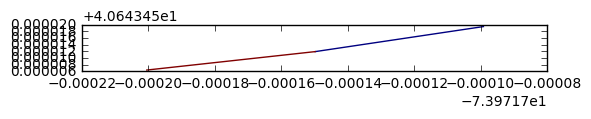

In [24]:
gpsDataPoints.plot(column='V')